In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [3]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


import torch
import gc
# from GPUtil import showUtilization as gpu_usage


## shared code

In [4]:
# essential functions 
def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [5]:
# extract the main info from the label into three columns 

def write_break_down_columns(old_caption_file, new_caption_file):
    with open(old_caption_file, 'r') as f:
        for line in f:
            # skip title
            if 'image,caption,psum,psum_sq' in line:
                continue

            image_name, text_label,psum,psum_sq = line.split(',')
            text_label = text_label.strip()

            struc_label = Caption(text_label, support_plural=True).get_structured()
            first_object = struc_label['objects'][0]
            mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
            write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{psum},{psum_sq}")


In [6]:
# write back the class number to the annotiation file
def get_image_class(item, classes_map):
    for k,v in classes_map.items():
        if v == item:
            return k
    return None
    
def write_class_colum(df, with_class_caption_file, classes_map):
    for _,line in df.iterrows():
        image_name,charge,mod,color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['psum'],line['psum_sq']
        image_class = get_image_class((charge, mod, color),classes_map)

        write_line_to_file(with_class_caption_file, f"{image_name},{charge},{mod},{color},{psum},{psum_sq},{image_class}")


In [7]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")
#         print(img)
        # apply the transfromation to the image
        if self.transform is not None:
#             print('self.transform is not None')
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)
#         print('img_t: ',img_t)

        return img_t

    def _get_label_class(self, idx):
        
        label_class = self.classes[idx]
#         if self.transform is not None:
#             label_class_t = self.transform(label_class)
#         else:
#             trans = T.ToTensor()
#             label_class_t = trans(label_class)

        return label_class

    



In [8]:
def visualize_one_batch(data_loader):
    # Visualize one training batch
    for images,classes,_,_,_ in data_loader:
        print(type(classes))
        fig, ax = plt.subplots(figsize = (25, 25))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 5).permute(1,2,0))
        break


In [9]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [63]:
### Training Code
from src.pytorchtools import EarlyStopping, EarlyStoppingAccuracy

def train_classification_model(model, optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device):
    from tqdm import tqdm
    
    # initialize the early_stopping object
    checkpoint_file=f"{data_location}/classification-checkpoint.pt"
    early_stopping = EarlyStoppingAccuracy(patience=10, verbose=True, path=checkpoint_file)

    for epoch in range(epochs):
        start = time.time()

        #Epoch Loss & Accuracy
        train_epoch_loss = []
        train_epoch_accuracy = []
        _iter = 1

        #Val Loss & Accuracy
        val_epoch_loss = []
        val_epoch_accuracy = []

        # Training
        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
            for images, labels,_,_,_ in tepoch: 
                images = images.to(device)
                labels = labels.to(device)

                #Reset Grads
                optimizer.zero_grad()

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss & Backward, Update Weights (Step)
                loss = criterion(preds, labels)
                loss.backward()
                optimizer.step()
#                 lr_scheduler.step()
                
                #Append loss & acc
                loss_value = loss.item()
                train_epoch_loss.append(loss_value)
                train_epoch_accuracy.append(acc)

                tepoch.set_postfix({'train_epoch_loss': loss_value})
    #             tepoch.set_postfix({'train_epoch_accuracy',acc})

                if _iter % 500 == 0:
                    print("> Iteration {} < ".format(_iter))
                    print("Iter Loss = {}".format(round(loss_value, 4)))
                    print("Iter Accuracy = {} % \n".format(acc))

                _iter += 1

        # tryinf to free the memory
#         gc.collect()
#         torch.cuda.empty_cache()
#         gpu_usage()                             

        #Validation
        with tqdm(val_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for images, labels,_,_,_ in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss
                loss = criterion(preds, labels)

                #Append loss & acc
                loss_value = loss.item()
                val_epoch_loss.append(loss_value)
                val_epoch_accuracy.append(acc)
                tepoch.set_postfix({'val_epoch_loss': loss_value})
    #             tepoch.set_postfix({'val_epoch_accuracy',acc})


        train_epoch_loss = np.mean(train_epoch_loss)
        train_epoch_accuracy = np.mean(train_epoch_accuracy)

        val_epoch_loss = np.mean(val_epoch_loss)
        val_epoch_accuracy = np.mean(val_epoch_accuracy)

        end = time.time()

        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        #Print Epoch Statistics
        print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
        print("Train Loss = {}".format(round(train_epoch_loss, 4)))
        print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
        print("Val Loss = {}".format(round(val_epoch_loss, 4)))
        print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
        
        early_stopping(val_epoch_accuracy, model, optimizer, epoch)
           
        if early_stopping.early_stop:
            print("Early stopping. Stopping the training of the model.")
            break

    return model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy




In [61]:
def test_classification_model(model, test_data_loader):
    test_epoch_loss = []
    test_epoch_accuracy = []

    test_loss = []
    test_accuracy = []

    # model.eval()
    with torch.no_grad():
        for images, labels,_,_,_ in test_data_loader:
            print(type(labels))
            images = images.to("cpu")
            labels = labels.to("cpu")

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            test_epoch_loss.append(loss_value)
            test_epoch_accuracy.append(acc)

    test_epoch_loss = np.mean(test_epoch_loss)
    test_epoch_accuracy = np.mean(test_epoch_accuracy)

    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

    print("Test Loss = {}".format(round(test_epoch_loss, 4)))
    print("Test Accuracy = {} % \n".format(test_epoch_accuracy))



# Train on dataset with single object

## Data preprocessing 

In [19]:

MISSING_TOKEN = 'None'

In [20]:
# data_location =  '../baseline-gen-data/small/'
data_location =  '/home/salnabulsi/coat-of-arms/data/new/'
caption_file = data_location + 'test_real_captions_psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq.txt'




In [21]:
creat_caption_file(new_caption_file, 'image,charge,mod,color,psum,psum_sq')


In [22]:
write_break_down_columns(caption_file, new_caption_file)

In [23]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,psum,psum_sq
0,6423_G A cross.jpg,cross,None,A,19754.472656,15046.065430
1,1739_A G cross patonce.jpg,cross,patonce,G,18735.156250,14356.203125
2,2870_O S lion rampant.jpg,lion,rampant,S,15362.364258,9554.638672
3,18746_S A eagle.jpg,eagle,None,A,13549.989258,9141.958984
4,29836_G O 3 eagles.jpg,eagles,None,O,16778.851562,13274.360352
...,...,...,...,...,...,...
172,29394_G O eagle doubleheaded.jpg,eagle,doubleheaded,O,15421.950195,11365.047852
173,398_A S lion rampant.jpg,lion,rampant,S,18646.660156,14093.865234
174,4459_B O eagle.jpg,eagle,None,O,17065.537109,11514.578125
175,5302_O B cross moline.jpg,cross,moline,B,18390.984375,13203.470703


In [24]:
# Getting classes
column_values = df[['charge','mod', 'color']].value_counts(dropna=False)
column_values

charge  mod           color
lion    rampant       O        16
                      G        12
eagle   None          O        11
lion    rampant       S        10
                      A        10
                      B         9
eagle   None          A         8
cross   None          A         7
                      G         7
lions   passt guard   O         7
eagle   None          S         7
                      G         5
        doubleheaded  S         5
cross   moline        G         5
        None          S         5
eagles  None          O         4
lions   passt guard   S         4
eagle   doubleheaded  A         3
eagles  None          A         3
lions   None          S         3
                      A         3
eagle   doubleheaded  G         3
cross   None          B         2
eagle   doubleheaded  O         2
eagles  None          G         2
cross   moline        O         2
        None          O         2
        moline        B         2
lions   None        

In [25]:
classes = list(column_values.to_dict().keys())
classes

[('lion', 'rampant', 'O'),
 ('lion', 'rampant', 'G'),
 ('eagle', 'None', 'O'),
 ('lion', 'rampant', 'S'),
 ('lion', 'rampant', 'A'),
 ('lion', 'rampant', 'B'),
 ('eagle', 'None', 'A'),
 ('cross', 'None', 'A'),
 ('cross', 'None', 'G'),
 ('lions', 'passt guard', 'O'),
 ('eagle', 'None', 'S'),
 ('eagle', 'None', 'G'),
 ('eagle', 'doubleheaded', 'S'),
 ('cross', 'moline', 'G'),
 ('cross', 'None', 'S'),
 ('eagles', 'None', 'O'),
 ('lions', 'passt guard', 'S'),
 ('eagle', 'doubleheaded', 'A'),
 ('eagles', 'None', 'A'),
 ('lions', 'None', 'S'),
 ('lions', 'None', 'A'),
 ('eagle', 'doubleheaded', 'G'),
 ('cross', 'None', 'B'),
 ('eagle', 'doubleheaded', 'O'),
 ('eagles', 'None', 'G'),
 ('cross', 'moline', 'O'),
 ('cross', 'None', 'O'),
 ('cross', 'moline', 'B'),
 ('lions', 'None', 'G'),
 ('cross', 'moline', 'S'),
 ('lion', 'rampant', 'V'),
 ('lions', 'None', 'B'),
 ('lions', 'passt', 'G'),
 ('lions', 'None', 'O'),
 ('lions', 'passt guard', 'A'),
 ('cross', 'moline', 'A'),
 ('cross', 'None', 'V

In [26]:
len(classes)

43

In [27]:
type(classes[0])

tuple

In [28]:
# Give unique number to each class, , easier than handeling an enum of three strings!

CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('lion', 'rampant', 'O'),
 1: ('lion', 'rampant', 'G'),
 2: ('eagle', 'None', 'O'),
 3: ('lion', 'rampant', 'S'),
 4: ('lion', 'rampant', 'A'),
 5: ('lion', 'rampant', 'B'),
 6: ('eagle', 'None', 'A'),
 7: ('cross', 'None', 'A'),
 8: ('cross', 'None', 'G'),
 9: ('lions', 'passt guard', 'O'),
 10: ('eagle', 'None', 'S'),
 11: ('eagle', 'None', 'G'),
 12: ('eagle', 'doubleheaded', 'S'),
 13: ('cross', 'moline', 'G'),
 14: ('cross', 'None', 'S'),
 15: ('eagles', 'None', 'O'),
 16: ('lions', 'passt guard', 'S'),
 17: ('eagle', 'doubleheaded', 'A'),
 18: ('eagles', 'None', 'A'),
 19: ('lions', 'None', 'S'),
 20: ('lions', 'None', 'A'),
 21: ('eagle', 'doubleheaded', 'G'),
 22: ('cross', 'None', 'B'),
 23: ('eagle', 'doubleheaded', 'O'),
 24: ('eagles', 'None', 'G'),
 25: ('cross', 'moline', 'O'),
 26: ('cross', 'None', 'O'),
 27: ('cross', 'moline', 'B'),
 28: ('lions', 'None', 'G'),
 29: ('cross', 'moline', 'S'),
 30: ('lion', 'rampant', 'V'),
 31: ('lions', 'None', 'B'),
 32: ('lions'

In [29]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])

In [30]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq.txt'


In [31]:
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')


In [32]:
write_class_colum(df, new_with_class_caption_file, CLASSES_MAP)
    

In [33]:

df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,6423_G A cross.jpg,cross,None,A,19754.472656,15046.065430,7
1,1739_A G cross patonce.jpg,cross,patonce,G,18735.156250,14356.203125,42
2,2870_O S lion rampant.jpg,lion,rampant,S,15362.364258,9554.638672,3
3,18746_S A eagle.jpg,eagle,None,A,13549.989258,9141.958984,6
4,29836_G O 3 eagles.jpg,eagles,None,O,16778.851562,13274.360352,15
...,...,...,...,...,...,...,...
172,29394_G O eagle doubleheaded.jpg,eagle,doubleheaded,O,15421.950195,11365.047852,23
173,398_A S lion rampant.jpg,lion,rampant,S,18646.660156,14093.865234,3
174,4459_B O eagle.jpg,eagle,None,O,17065.537109,11514.578125,2
175,5302_O B cross moline.jpg,cross,moline,B,18390.984375,13203.470703,27


In [34]:
# train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq.txt'
val_annotation_file  = data_location + '/val_labels_psumsq.txt'
test_annotation_file  = data_location + '/test_labels_psumsq.txt'

# train.to_csv(train_annotation_file, sep=',',index=False)
# test.to_csv(test_annotation_file, sep=',',index=False)
# validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 106 train images
There are 35 val images
There are 36 test images


,image,charge,mod,color,psum,psum_sq,class
0,87_G A cross.jpg,cross,None,A,16607.636719,11454.643555,7
1,4382_B A 2 lions passt guard.jpg,lions,passt guard,A,16040.631836,11036.284180,34
2,17941_A G lion rampant.jpg,lion,rampant,G,19688.000000,15166.090820,1
3,4289_V A lion rampant.jpg,lion,rampant,A,17711.251953,12160.342773,4
4,6610_O S lion rampant.jpg,lion,rampant,S,15834.119141,10824.548828,3
5,21370_A B lion rampant.jpg,lion,rampant,B,18375.636719,13869.170898,5
6,3921_A S 2 lions passt guard.jpg,lions,passt guard,S,18216.380859,13140.337891,16
7,32013_B A lion rampant.jpg,lion,rampant,A,15471.375977,9641.772461,4
8,1537_A S eagle doubleheaded.jpg,eagle,doubleheaded,S,18435.945312,13167.025391,12
9,19320_A S cross.jpg,cross,None,S,14748.231445,11295.405273,14


# Dataset and Dataloader  

In [35]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [36]:
BATCH_SIZE = 56
NUM_WORKER = 2 #### this needs multi-core
# NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [37]:
images_location = data_location + '/resized'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [38]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(56, 0)), tensor([], size=(56, 0)))

In [39]:
mean = get_mean(train_dataset, train_data_loader, 500 , 500)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [40]:
std = get_std(train_dataset, train_data_loader, mean, 500 , 500)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


In [41]:
mean, std

(tensor(0.0228, dtype=torch.float64), tensor(0.1258, dtype=torch.float64))

# Dataset and Dataloader  

In [42]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [43]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=/home/salnabulsi/coat-of-arms/data/new//resized, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.022752675621560536, std=0.1257942304766321)
 ), device=cuda:0, df=                                image  charge           mod color  \
 0                    47_A S eagle.jpg   eagle          None     S   
 1               6397_B O 3 eagles.jpg  eagles          None     O   
 2             70_A G cross moline.jpg   cross        moline     G   
 3    12396_G O eagle doubleheaded.jpg   eagle  doubleheaded     O   
 4           7350_A V lion rampant.jpg    lion       rampant     V   
 ..                                ...     ...           ...   ...   
 101               29743_O A eagle.jpg   eagle          None     A   
 102        22323_O S cross moline.jpg   cross        moline     S   
 103            29836_G O 3 eagles.jpg  

In [44]:
# Data Loader  -  using Sampler (YT Video)

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


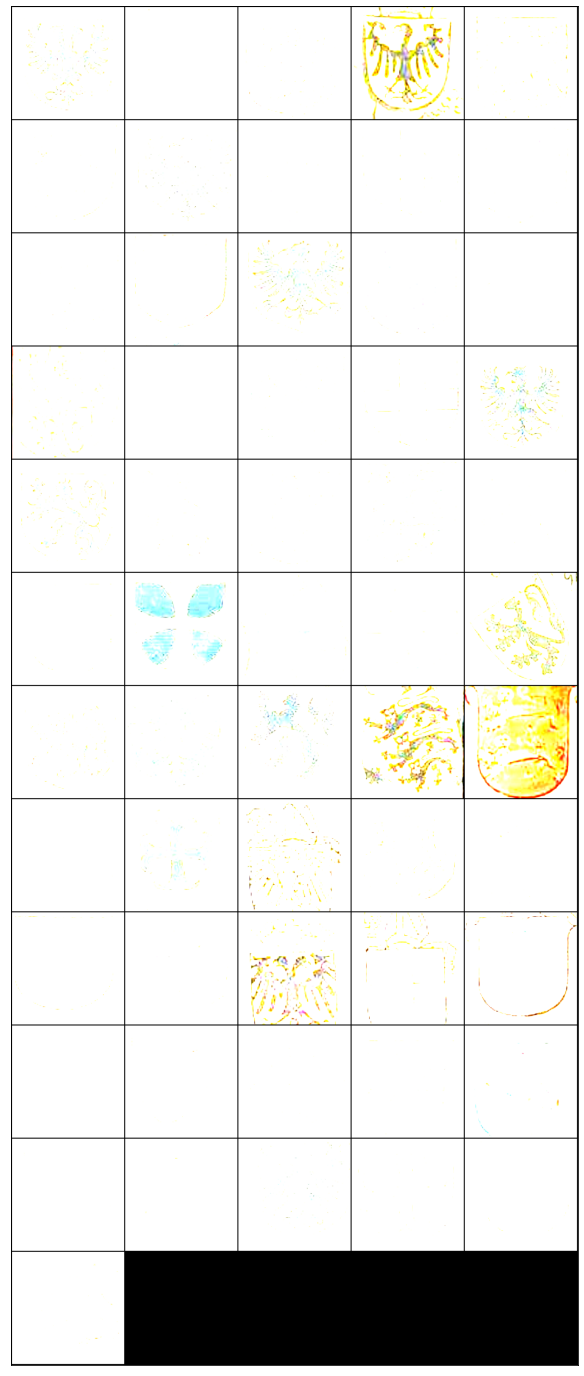

In [45]:


visualize_one_batch(train_data_loader)

Caption: 10303_A B cross.jpg cross rampant B
(100, 97, 3)


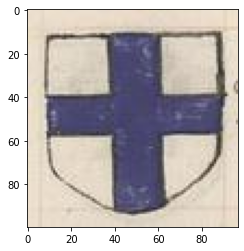

In [46]:
import matplotlib.image as mpimg
i = 8
image_path = images_location +'/'+ df1.iloc[i,0]
print("Caption:", df1.iloc[i,0], df1.iloc[i,1], df.iloc[i,2],df1.iloc[i,3])
img=mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


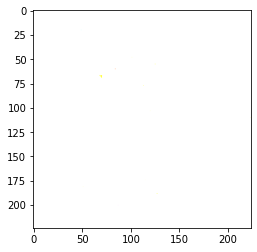

In [47]:
dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
img = images[0]
# print(img)
# img=mpimg.imread(image_path)
print(img.shape)
# plt.imshow(img)
plt.imshow(img.permute(1,2,0))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


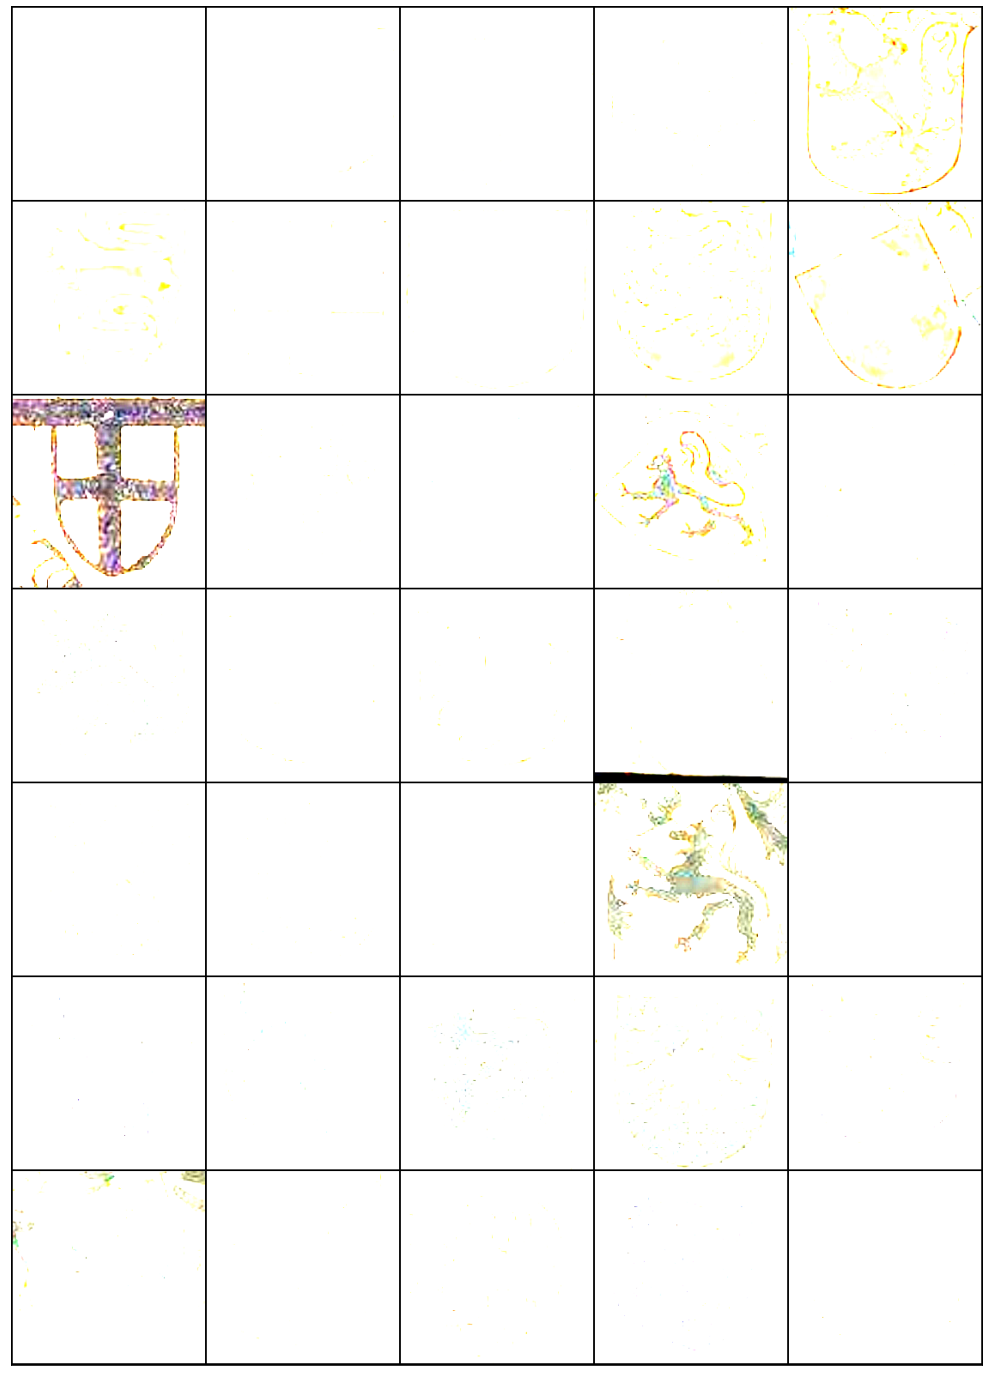

In [48]:
visualize_one_batch(val_data_loader)

# Model Definition

In [49]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


In [50]:

# from torchviz import make_dot, make_dot_from_trace

# make_dot(model, params=dict(model.named_parameters()))


# Model Training, Validation and Testing

In [64]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 100
CUDA_LAUNCH_BLOCKING=1

In [65]:

model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model,optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device)


Epoch 0:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-0 lr: 0.0001


Epoch 0: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/batch, val_epoch_loss=5.2]


** Epoch 0 ** - Epoch Time 2
Train Loss = 0.5209
Train Accuracy = 88.0 % 

Val Loss = 5.196
Val Accuracy = 40.0 % 

Accuracy increased (0.000000 --> 40.000000).  Saving model ...


Epoch 1:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-1 lr: 0.0001


Epoch 1: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.22s/batch, val_epoch_loss=3.84]


** Epoch 1 ** - Epoch Time 2
Train Loss = 0.4344
Train Accuracy = 88.75 % 

Val Loss = 3.8374
Val Accuracy = 37.1429 % 

EarlyStopping counter: 1 out of 10


Epoch 2:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-2 lr: 0.0001


Epoch 2: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.10s/batch, val_epoch_loss=3.33]


** Epoch 2 ** - Epoch Time 2
Train Loss = 0.1675
Train Accuracy = 94.32145 % 

Val Loss = 3.3319
Val Accuracy = 40.0 % 

Accuracy increased (40.000000 --> 40.000000).  Saving model ...


Epoch 3:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-3 lr: 0.0001


Epoch 3: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.22s/batch, val_epoch_loss=3.89]


** Epoch 3 ** - Epoch Time 2
Train Loss = 0.1072
Train Accuracy = 99.10714999999999 % 

Val Loss = 3.8949
Val Accuracy = 37.1429 % 

EarlyStopping counter: 1 out of 10


Epoch 4:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-4 lr: 0.0001


Epoch 4: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.12s/batch, val_epoch_loss=4.25]


** Epoch 4 ** - Epoch Time 2
Train Loss = 0.0664
Train Accuracy = 99.10714999999999 % 

Val Loss = 4.2461
Val Accuracy = 40.0 % 

Accuracy increased (40.000000 --> 40.000000).  Saving model ...


Epoch 5:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-5 lr: 0.0001


Epoch 5: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.18s/batch, val_epoch_loss=5.05]


** Epoch 5 ** - Epoch Time 2
Train Loss = 0.0267
Train Accuracy = 99.0 % 

Val Loss = 5.0546
Val Accuracy = 37.1429 % 

EarlyStopping counter: 1 out of 10


Epoch 6:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-6 lr: 0.0001


Epoch 6: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.19s/batch, val_epoch_loss=5.08]


** Epoch 6 ** - Epoch Time 2
Train Loss = 0.089
Train Accuracy = 96.10714999999999 % 

Val Loss = 5.0778
Val Accuracy = 42.8571 % 

Accuracy increased (40.000000 --> 42.857100).  Saving model ...


Epoch 7:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-7 lr: 0.0001


Epoch 7: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.17s/batch, val_epoch_loss=5.18]


** Epoch 7 ** - Epoch Time 2
Train Loss = 0.0245
Train Accuracy = 98.10714999999999 % 

Val Loss = 5.1762
Val Accuracy = 48.5714 % 

Accuracy increased (42.857100 --> 48.571400).  Saving model ...


Epoch 8:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-8 lr: 0.0001


Epoch 8: 100%|██████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/batch, val_epoch_loss=5]


** Epoch 8 ** - Epoch Time 2
Train Loss = 0.0203
Train Accuracy = 99.10714999999999 % 

Val Loss = 5.0022
Val Accuracy = 37.1429 % 

EarlyStopping counter: 1 out of 10


Epoch 9:   0%|                                                                | 0/2 [00:00<?, ?batch/s]

Epoch-9 lr: 0.0001


Epoch 9: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.18s/batch, val_epoch_loss=4.81]


** Epoch 9 ** - Epoch Time 2
Train Loss = 0.0246
Train Accuracy = 99.10714999999999 % 

Val Loss = 4.8118
Val Accuracy = 37.1429 % 

EarlyStopping counter: 2 out of 10


Epoch 10:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-10 lr: 0.0001


Epoch 10: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.21s/batch, val_epoch_loss=4.53]


** Epoch 10 ** - Epoch Time 2
Train Loss = 0.0085
Train Accuracy = 100.0 % 

Val Loss = 4.5287
Val Accuracy = 22.8571 % 

EarlyStopping counter: 3 out of 10


Epoch 11:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-11 lr: 0.0001


Epoch 11: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.20s/batch, val_epoch_loss=4.77]


** Epoch 11 ** - Epoch Time 2
Train Loss = 0.0218
Train Accuracy = 99.0 % 

Val Loss = 4.7661
Val Accuracy = 31.4286 % 

EarlyStopping counter: 4 out of 10


Epoch 12:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-12 lr: 0.0001


Epoch 12: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.19s/batch, val_epoch_loss=4.37]


** Epoch 12 ** - Epoch Time 2
Train Loss = 0.0026
Train Accuracy = 100.0 % 

Val Loss = 4.3742
Val Accuracy = 40.0 % 

EarlyStopping counter: 5 out of 10


Epoch 13:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-13 lr: 0.0001


Epoch 13: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.25s/batch, val_epoch_loss=5.15]


** Epoch 13 ** - Epoch Time 2
Train Loss = 0.0135
Train Accuracy = 99.0 % 

Val Loss = 5.1472
Val Accuracy = 37.1429 % 

EarlyStopping counter: 6 out of 10


Epoch 14:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-14 lr: 0.0001


Epoch 14: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.20s/batch, val_epoch_loss=5.9]


** Epoch 14 ** - Epoch Time 2
Train Loss = 0.0119
Train Accuracy = 100.0 % 

Val Loss = 5.9018
Val Accuracy = 31.4286 % 

EarlyStopping counter: 7 out of 10


Epoch 15:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-15 lr: 0.0001


Epoch 15: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.17s/batch, val_epoch_loss=5.08]


** Epoch 15 ** - Epoch Time 2
Train Loss = 0.0186
Train Accuracy = 99.10714999999999 % 

Val Loss = 5.0832
Val Accuracy = 31.4286 % 

EarlyStopping counter: 8 out of 10


Epoch 16:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-16 lr: 0.0001


Epoch 16: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.23s/batch, val_epoch_loss=4.73]


** Epoch 16 ** - Epoch Time 2
Train Loss = 0.005
Train Accuracy = 100.0 % 

Val Loss = 4.7289
Val Accuracy = 42.8571 % 

EarlyStopping counter: 9 out of 10


Epoch 17:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-17 lr: 0.0001


Epoch 17: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.17s/batch, val_epoch_loss=4.51]


** Epoch 17 ** - Epoch Time 2
Train Loss = 0.0005
Train Accuracy = 100.0 % 

Val Loss = 4.5121
Val Accuracy = 51.4286 % 

Accuracy increased (48.571400 --> 51.428600).  Saving model ...


Epoch 18:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-18 lr: 0.0001


Epoch 18: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.17s/batch, val_epoch_loss=4.69]


** Epoch 18 ** - Epoch Time 2
Train Loss = 0.0046
Train Accuracy = 100.0 % 

Val Loss = 4.6867
Val Accuracy = 57.1429 % 

Accuracy increased (51.428600 --> 57.142900).  Saving model ...


Epoch 19:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-19 lr: 0.0001


Epoch 19: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.14s/batch, val_epoch_loss=4.21]


** Epoch 19 ** - Epoch Time 2
Train Loss = 0.0006
Train Accuracy = 100.0 % 

Val Loss = 4.2145
Val Accuracy = 54.2857 % 

EarlyStopping counter: 1 out of 10


Epoch 20:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-20 lr: 0.0001


Epoch 20: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.28s/batch, val_epoch_loss=4.89]


** Epoch 20 ** - Epoch Time 3
Train Loss = 0.0007
Train Accuracy = 100.0 % 

Val Loss = 4.8909
Val Accuracy = 40.0 % 

EarlyStopping counter: 2 out of 10


Epoch 21:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-21 lr: 0.0001


Epoch 21: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.20s/batch, val_epoch_loss=5.59]


** Epoch 21 ** - Epoch Time 2
Train Loss = 0.0005
Train Accuracy = 100.0 % 

Val Loss = 5.5858
Val Accuracy = 48.5714 % 

EarlyStopping counter: 3 out of 10


Epoch 22:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-22 lr: 0.0001


Epoch 22: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.21s/batch, val_epoch_loss=4.89]


** Epoch 22 ** - Epoch Time 2
Train Loss = 0.0007
Train Accuracy = 100.0 % 

Val Loss = 4.8897
Val Accuracy = 51.4286 % 

EarlyStopping counter: 4 out of 10


Epoch 23:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-23 lr: 0.0001


Epoch 23: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.24s/batch, val_epoch_loss=5.58]


** Epoch 23 ** - Epoch Time 2
Train Loss = 0.0035
Train Accuracy = 100.0 % 

Val Loss = 5.5835
Val Accuracy = 48.5714 % 

EarlyStopping counter: 5 out of 10


Epoch 24:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-24 lr: 0.0001


Epoch 24: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.22s/batch, val_epoch_loss=4.77]


** Epoch 24 ** - Epoch Time 2
Train Loss = 0.0003
Train Accuracy = 100.0 % 

Val Loss = 4.7709
Val Accuracy = 45.7143 % 

EarlyStopping counter: 6 out of 10


Epoch 25:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-25 lr: 0.0001


Epoch 25: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.28s/batch, val_epoch_loss=4.93]


** Epoch 25 ** - Epoch Time 3
Train Loss = 0.0003
Train Accuracy = 100.0 % 

Val Loss = 4.9336
Val Accuracy = 48.5714 % 

EarlyStopping counter: 7 out of 10


Epoch 26:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-26 lr: 0.0001


Epoch 26: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.21s/batch, val_epoch_loss=4.79]


** Epoch 26 ** - Epoch Time 2
Train Loss = 0.0001
Train Accuracy = 100.0 % 

Val Loss = 4.7882
Val Accuracy = 45.7143 % 

EarlyStopping counter: 8 out of 10


Epoch 27:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-27 lr: 0.0001


Epoch 27: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.18s/batch, val_epoch_loss=4.91]


** Epoch 27 ** - Epoch Time 2
Train Loss = 0.0001
Train Accuracy = 100.0 % 

Val Loss = 4.9071
Val Accuracy = 51.4286 % 

EarlyStopping counter: 9 out of 10


Epoch 28:   0%|                                                               | 0/2 [00:00<?, ?batch/s]

Epoch-28 lr: 0.0001


Epoch 28: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.18s/batch, val_epoch_loss=5.52]

** Epoch 28 ** - Epoch Time 2
Train Loss = 0.0001
Train Accuracy = 100.0 % 

Val Loss = 5.5166
Val Accuracy = 42.8571 % 

EarlyStopping counter: 10 out of 10
Early stopping. Stopping the training of the model.


## Save model to disk

In [66]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-trained-on-only-real-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [67]:
model_full_path

'/home/salnabulsi/coat-of-arms/data/new//classification-model-trained-on-only-real-02-26-2023-16:12:59.pth'

In [68]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test model on synthetic data


In [69]:
# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


model_file_path =  data_location + '/classification-model-trained-on-only-real-02-26-2023-16:12:59.pth'
saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
criterion = nn.CrossEntropyLoss()

loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [70]:
#this cell execution from real classification-model-trained-on-only-real-02-26-2023-13:04:13.pth
test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
Test Loss = 4.4935
Test Accuracy = 41.6667 % 



In [72]:
import torch
import random
seed = 1234
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
Test Loss = 4.2466
Test Accuracy = 36.1111 % 

